In [1]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [8]:
from math import ceil
from functools import partial
from pathlib import Path
import datetime

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import dask
import cftime

from project.io import IntakeESMLoader, save_mfdataset
from project.plotting import plot_field
from project.util import stack_state, unstack_state, is_dask_array, get_data_path, average_annually
from project.eof import EOF, EOFXArray, EOFMethod
from project.spaces import PhysicalSpaceForecastSpaceMapper, Detrend, NanMask
from project.logger import logging_disabled

In [3]:
ds = xr.open_dataset("/home/enkf6/dstiller/test_io_output.nc", chunks=dict(time=1))[
    ["ohc700", "tas", "psl", "pr", "zg500"]
]

In [4]:
ds

<xarray.Dataset>
Dimensions:  (time: 480, lat: 90, lon: 180)
Coordinates:
  * time     (time) object 7001-01-16 12:00:00 ... 7040-12-16 12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    ohc700   (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    tas      (time, lat, lon) float32 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    psl      (time, lat, lon) float32 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    zg500    (time, lat, lon) float32 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>

In [5]:
data = ds["zg500"].isel(time=slice(None, 100)).dropna("lat")
data = stack_state(data)
data -= data.mean(dim="time")
data

<xarray.DataArray '' (state: 15840, time: 100)>
dask.array<sub, shape=(15840, 100), dtype=float32, chunksize=(15840, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 7001-01-16 12:00:00 ... 7009-04-16 00:00:00
  * state    (state) object MultiIndex
  * field    (state) object 'zg500' 'zg500' 'zg500' ... 'zg500' 'zg500' 'zg500'
  * lon      (state) float64 0.0 0.0 0.0 0.0 0.0 ... 358.0 358.0 358.0 358.0
  * lat      (state) float64 -87.0 -85.0 -83.0 -81.0 ... 81.0 83.0 85.0 87.0
Attributes:
    standard_name:  geopotential_height
    long_name:      Geopotential Height
    units:          m
    realm:          atmos
    regrid_method:  bilinear

In [6]:
eof = EOFXArray(10)
eof.fit(data)

2023-12-09 12:03:07   DEBUG Calculating EOFs using Dask (rank = 10)


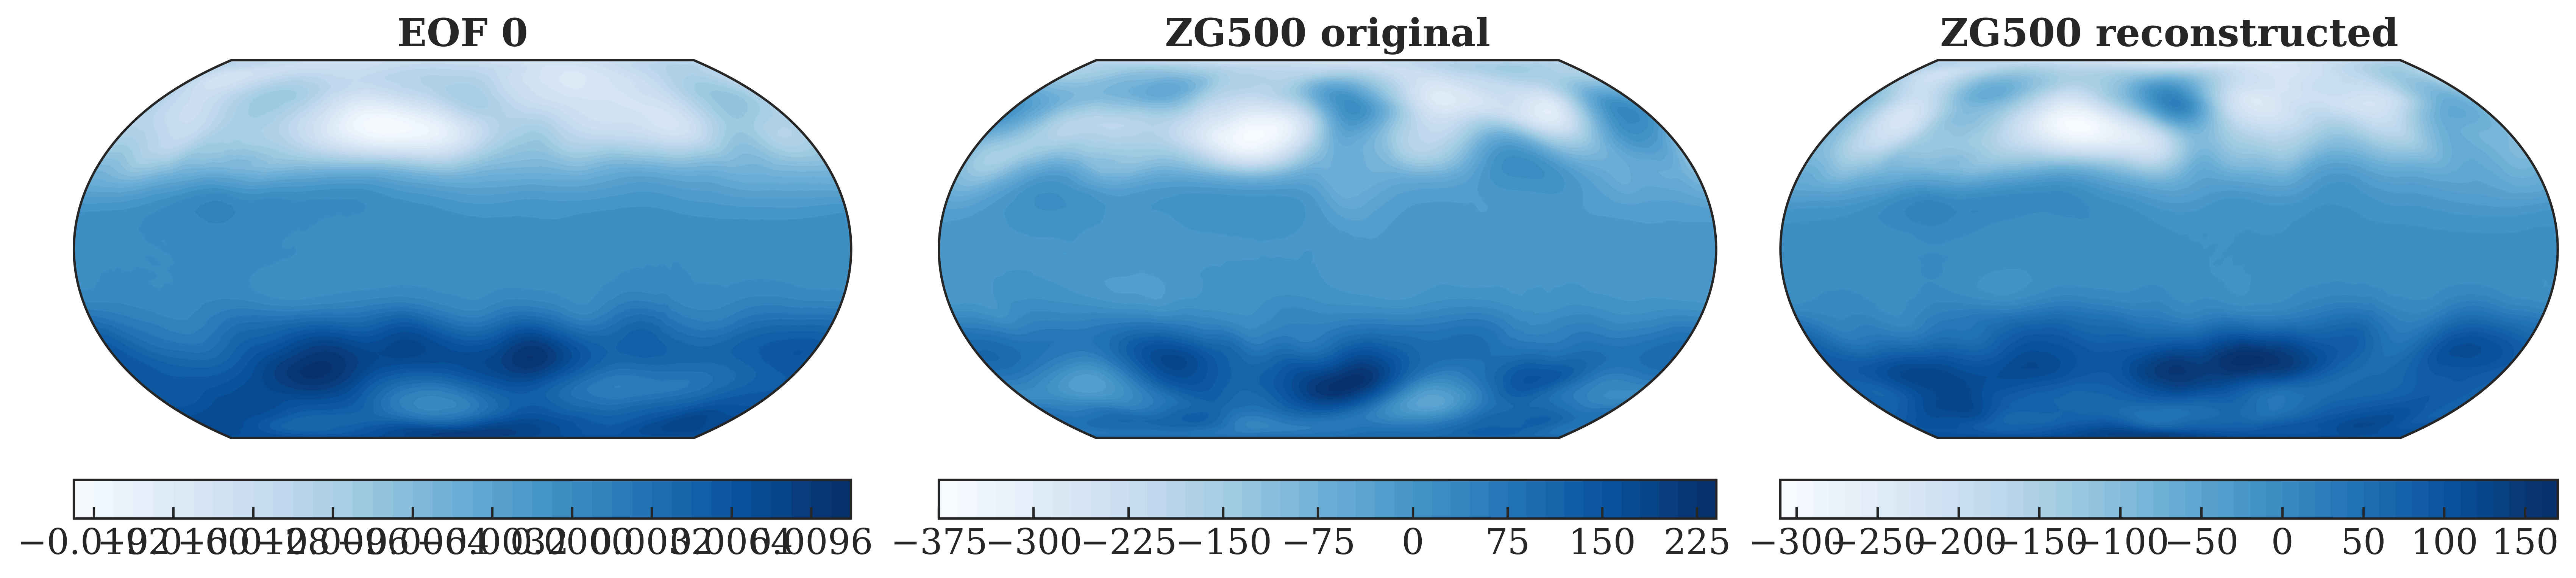

In [26]:
fig, axs = plt.subplots(
    1,
    3,
    figsize=(15, 5),
    subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=198)),
)

axs[0].set_title("EOF 0")
plot_field(axs[0], unstack_state(eof.get_component(0))["zg500"].T)

axs[1].set_title("ZG500 original")
plot_field(axs[1], unstack_state(data.isel(time=0))["zg500"].T)

axs[2].set_title("ZG500 reconstructed")
plot_field(
    axs[2],
    unstack_state(eof.project_backwards(eof.project_forwards(data.isel(time=0))))["zg500"].T,
)

In [9]:
data = average_annually(ds.isel(time=slice(None, 200)))

mapper = PhysicalSpaceForecastSpaceMapper(10, 30, 20, ["ohc700"], ["pr"])
mapper.fit(data)

In [46]:
# mapper.save(Path("/home/enkf6/dstiller/enspred/mapper"))

In [10]:
x = mapper.forward(data)
x

2023-12-09 12:04:00    INFO PhysicalSpaceForecastSpaceMapper.forward()
2023-12-09 12:04:00    INFO Splitting dataset into Dask arrays
2023-12-09 12:04:01    INFO Masking nans
2023-12-09 12:04:01    INFO Detrending data
2023-12-09 12:04:01    INFO Standardizing pr before individual EOF
2023-12-09 12:04:01    INFO Projecting EOF for ohc700 [1/5]
2023-12-09 12:04:01    INFO Standardizing ohc700 after individual EOF
2023-12-09 12:04:01    INFO Projecting EOF for tas [2/5]
2023-12-09 12:04:01    INFO Standardizing tas after individual EOF
2023-12-09 12:04:01    INFO Projecting EOF for psl [3/5]
2023-12-09 12:04:01    INFO Standardizing psl after individual EOF
2023-12-09 12:04:01    INFO Projecting EOF for pr [4/5]
2023-12-09 12:04:01    INFO Projecting EOF for zg500 [5/5]
2023-12-09 12:04:01    INFO Standardizing zg500 after individual EOF
2023-12-09 12:04:01    INFO Projecting joint EOF for zg500, pr, tas, psl
2023-12-09 12:04:01    INFO Appending direct fields for ohc700


dask.array<concatenate, shape=(32, 16), dtype=float64, chunksize=(16, 1), chunktype=numpy.ndarray>

In [63]:
y = mapper.backward(x, data.time)
y

2023-12-08 00:19:29    INFO PhysicalSpaceForecastSpaceMapper.backward()
2023-12-08 00:19:29    INFO Splitting direct fields for ohc700
2023-12-08 00:19:29    INFO Back-projecting joint EOF for pr, tas, psl, zg500
2023-12-08 00:19:29    INFO De-standardizing ohc700 after individual EOF
2023-12-08 00:19:29    INFO Back-projecting EOF for ohc700 [1/5]
2023-12-08 00:19:29    INFO De-standardizing tas after individual EOF
2023-12-08 00:19:29    INFO Back-projecting EOF for tas [2/5]
2023-12-08 00:19:29    INFO De-standardizing psl after individual EOF
2023-12-08 00:19:29    INFO Back-projecting EOF for psl [3/5]
2023-12-08 00:19:29    INFO Back-projecting EOF for pr [4/5]
2023-12-08 00:19:29    INFO De-standardizing zg500 after individual EOF
2023-12-08 00:19:29    INFO Back-projecting EOF for zg500 [5/5]
2023-12-08 00:19:29    INFO Un-masking nans
2023-12-08 00:19:29    INFO Merging Dask arrays into dataset


<xarray.Dataset>
Dimensions:  (lon: 180, lat: 90, time: 16)
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * time     (time) int64 7001 7002 7003 7004 7005 ... 7012 7013 7014 7015 7016
Data variables:
    ohc700   (time, lat, lon) float64 dask.array<chunksize=(16, 90, 180), meta=np.ndarray>
    tas      (time, lat, lon) float64 dask.array<chunksize=(16, 90, 180), meta=np.ndarray>
    psl      (time, lat, lon) float64 dask.array<chunksize=(16, 90, 180), meta=np.ndarray>
    pr       (time, lat, lon) float64 dask.array<chunksize=(16, 90, 180), meta=np.ndarray>
    zg500    (time, lat, lon) float64 dask.array<chunksize=(16, 90, 180), meta=np.ndarray>

In [ ]:
((y - data) ** 2).mean().compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    ohc700   float64 2.515e+16
    tas      float64 1.503
    psl      float64 6.25e+04
    pr       float64 1.795e-10

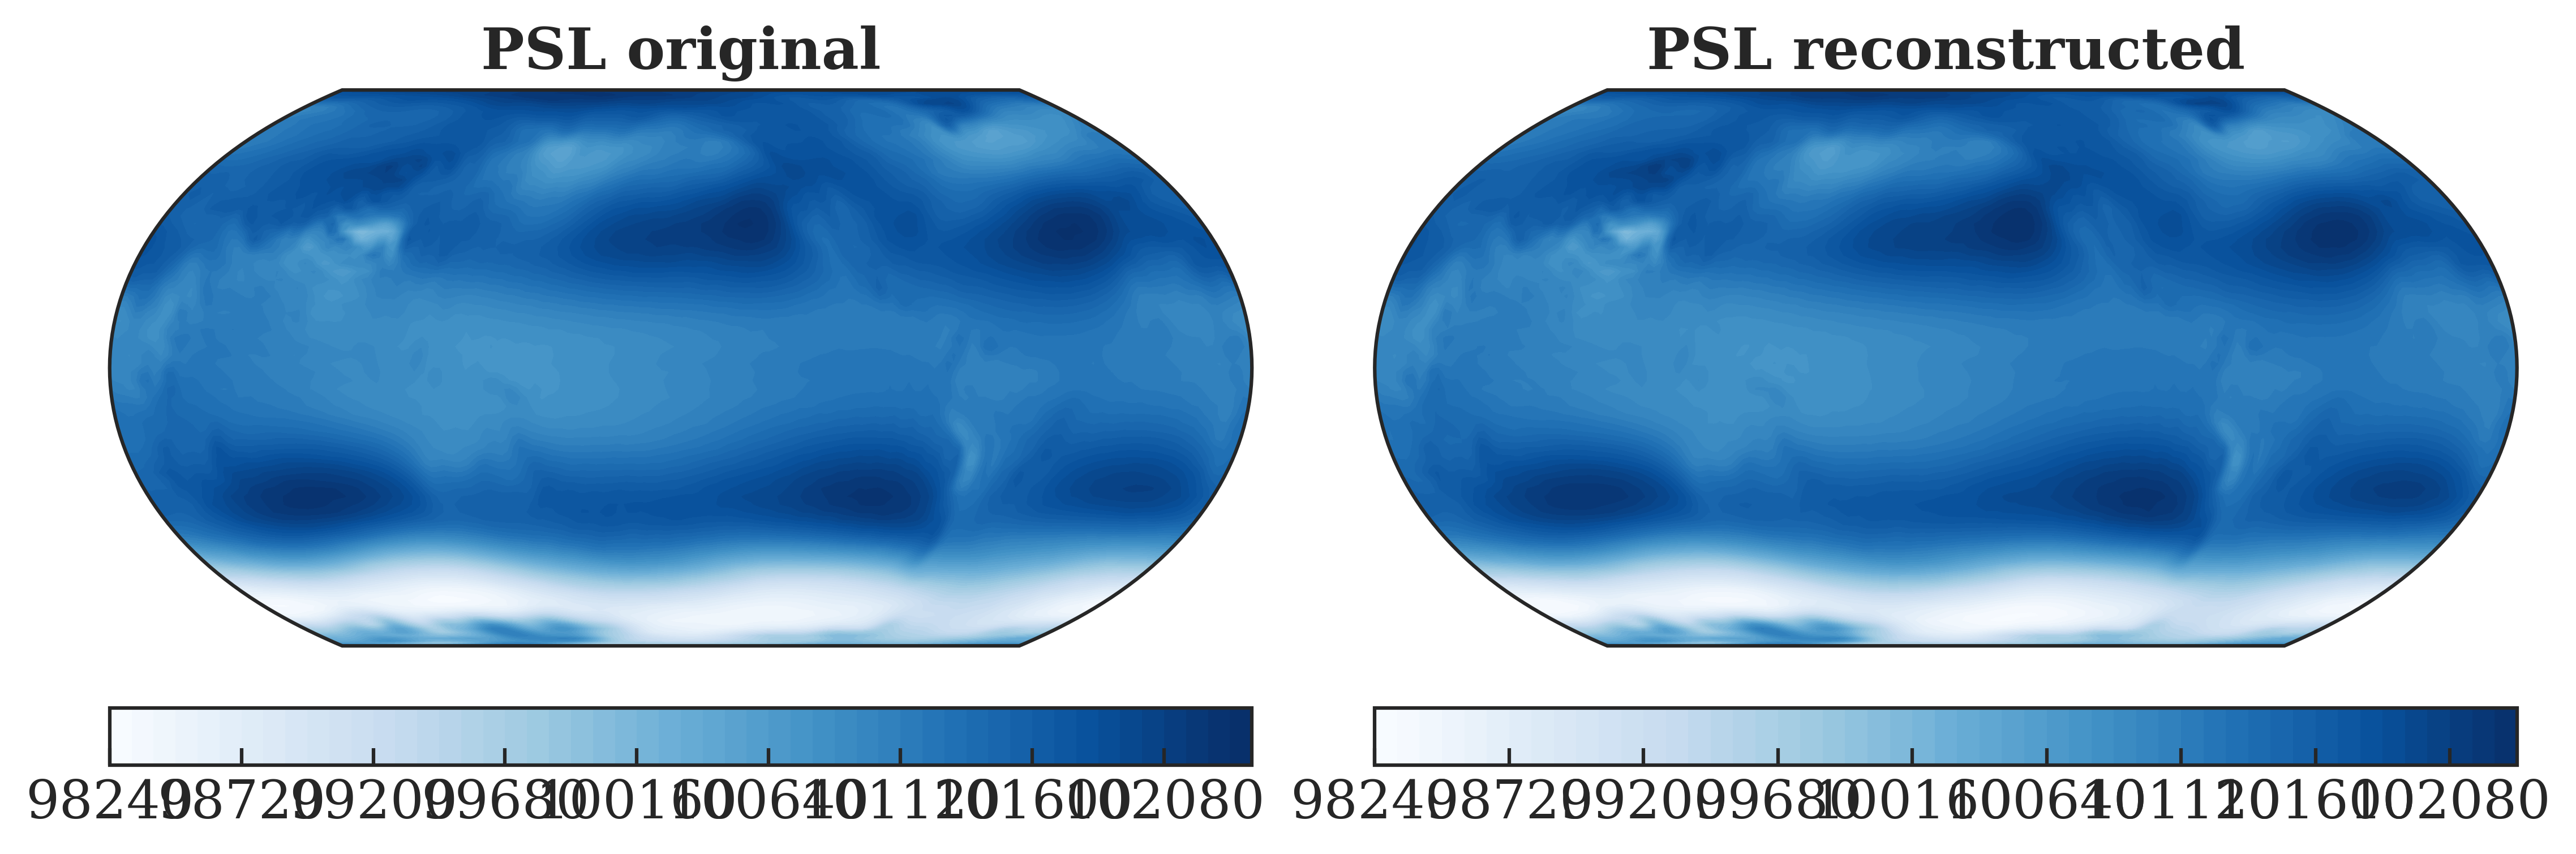

In [50]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(10, 5),
    subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=198)),
)

axs[0].set_title("PSL original")
plot_field(axs[0], data.isel(time=0)["psl"])

axs[1].set_title("PSL reconstructed")
plot_field(axs[1], y.isel(time=0)["psl"])